# Lymphoma classification - Heavily Augmented, Transformed dataset

### Importing the required libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
import cv2
import numpy as np
import pandas as pd
import glob
import os
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, Activation
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
import splitfolders
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

### Dataset visualisation

In [6]:
DATASET_PATH = 'D:\Research\Lymphoma_Classification\Lymphoma'

# There are three classes of images that we will deal with
cls = ['CLL', 'FL', 'MCL']

Text(0.5, 1.0, 'MCL')

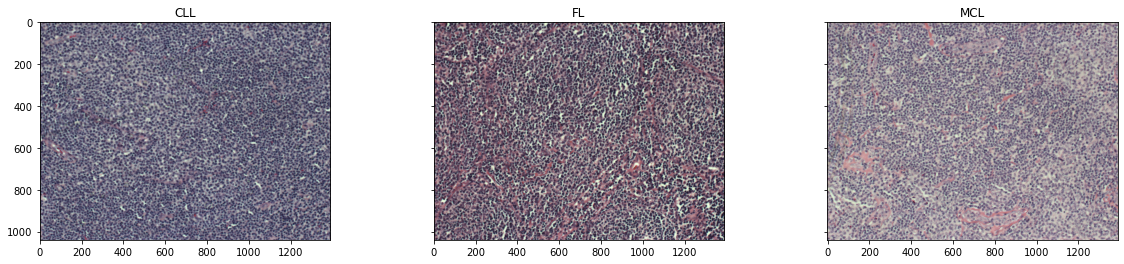

In [7]:
cll_path = os.path.join(DATASET_PATH, cls[0], '*')
cll = glob.glob(cll_path)
cll_img = io.imread(cll[0])

fl_path = os.path.join(DATASET_PATH, cls[1], '*')
fl = glob.glob(fl_path)
fl_img = io.imread(fl[0])

mcl_path = os.path.join(DATASET_PATH, cls[2], '*')
mcl = glob.glob(mcl_path)
mcl_img = io.imread(mcl[0])

f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(20)
        
axes[0].imshow(cll_img)
axes[1].imshow(fl_img)
axes[2].imshow(mcl_img)

axes[0].set_title('CLL')
axes[1].set_title('FL')
axes[2].set_title('MCL')

In [8]:
len(cll)

113

In [9]:
len(fl)

139

In [10]:
len(mcl)

122

In [11]:
cll_img.shape

(1040, 1388, 3)

In [12]:
fl_img.shape

(1040, 1388, 3)

In [13]:
mcl_img.shape

(1040, 1388, 3)

### Data Augmentation

In [12]:
cll_path = 'D:\Research\Lymphoma_Classification\Lymphoma\CLL'
fl_path = 'D:\Research\Lymphoma_Classification\Lymphoma\FL'
mcl_path = 'D:\Research\Lymphoma_Classification\Lymphoma\MCL'

In [5]:
# Augmenting the class CLL
aug = Augmentor.Pipeline(cll_path)
aug.resize(probability=1, width=224, height=224)
aug.rotate(probability=0.4, max_left_rotation=3, max_right_rotation=3)
aug.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
aug.sample(1500)

Initialised with 113 image(s) found.
Output directory set to D:\Research\Lymphoma_Classification\Lymphoma\CLL\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x2BE8AF08610>: 100%|██████████| 1500/1500 [00:35<00:00, 42.05 Samples/s]


In [6]:
#Augmenting the class FL
aug = Augmentor.Pipeline(fl_path)
aug.resize(probability=1, width=224, height=224)
aug.rotate(probability=0.4, max_left_rotation=3, max_right_rotation=3)
aug.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
aug.sample(1500)

Initialised with 139 image(s) found.
Output directory set to D:\Research\Lymphoma_Classification\Lymphoma\FL\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x2BE8AD6CF70>: 100%|██████████| 1500/1500 [00:36<00:00, 40.85 Samples/s]


In [ ]:
#Augmenting the class MCL
aug = Augmentor.Pipeline(mcl_path)
aug.resize(probability=1, width=224, height=224)
aug.rotate(probability=0.4, max_left_rotation=3, max_right_rotation=3)
aug.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
#aug.zoom(probability=0.2, min_factor=0.9, max_factor=0.9)
aug.sample(1500)

Initialised with 122 image(s) found.
Output directory set to D:\Research\Lymphoma_Classification\Lymphoma\MCL\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x2BE874170D0>:  68%|██████▊   | 1017/1500 [00:25<00:13, 35.32 Samples/s]

### Data transformation

#### Application of CLAHE on the augmented dataset

In [14]:
#applying CLAHE to the class CLL
clahe = cv2.createCLAHE()
path_cll=glob.glob("D:\Research\Lymphoma_Classification\Lymphoma\CLL\output\*.tif") 
images_cll=[]

for imagepath in path_cll:
    img=cv2.imread(imagepath)
    
    #changing the colour space to YCbCr
    img=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)  
    
    #applying clahe to individual colour components
    img_y = clahe.apply(img[:,:,0])
    img_cb = clahe.apply(img[:,:,1])
    img_cr = clahe.apply(img[:,:,2])
    #assembling the CLAHE applied image
    img_clahe = np.stack((img_y,img_cb,img_cr), axis=2)
    
    #changing the colour space back to RGB
    img_rgb = cv2.cvtColor(img_clahe,cv2.COLOR_YCR_CB2BGR) 
    images_cll.append(img_rgb)

In [15]:
#applying CLAHE to the class FL
path_fl=glob.glob("D:\Research\Lymphoma_Classification\Lymphoma\FL\output\*.tif")
images_fl=[]

for imagepath in path_fl:
    img=cv2.imread(imagepath)
    
    #changing the colour space to YCbCr
    img=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)  
    
    #applying clahe to individual colour components
    img_y = clahe.apply(img[:,:,0])
    img_cb = clahe.apply(img[:,:,1])
    img_cr = clahe.apply(img[:,:,2])
    #assembling the CLAHE applied image
    img_clahe = np.stack((img_y,img_cb,img_cr), axis=2)
    
    #changing the colour space back to RGB
    img_rgb = cv2.cvtColor(img_clahe,cv2.COLOR_YCR_CB2BGR) 
    images_fl.append(img_rgb)

In [16]:
#applying CLAHE to the class MCL
path_mcl=glob.glob("D:\Research\Lymphoma_Classification\Lymphoma\MCL\output\*.tif")
images_mcl=[]

for imagepath in path_mcl:
    
    
    #changing the colour space to YCbCr
    img=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)  
    
    #applying clahe to individual colour components
    img_y = clahe.apply(img[:,:,0])
    img_cb = clahe.apply(img[:,:,1])
    img_cr = clahe.apply(img[:,:,2])
    #assembling the CLAHE applied image
    img_clahe = np.stack((img_y,img_cb,img_cr), axis=2)
    
    #changing the colour space back to RGB
    img_rgb = cv2.cvtColor(img_clahe,cv2.COLOR_YCR_CB2BGR) 
    images_mcl.append(img_rgb)

#### Performing histogram matching on the dataset

In [ ]:
# reference image to which all the images will be matched
ref = images_cll[0]
#dataset path
parent_dir = "D:\\Research\\Lymphoma_Classification\\Heavy"

In [17]:
#creating a path to store the transformed images
folder = "CLL"
path = os.path.join(parent_dir, folder)
os.makedirs(path)

#applying histogram matching on images of class CLL and storing them
cll_hm = []
path_no = 1
for imgs in images_cll:
    hm = exposure.match_histograms(imgs, ref, multichannel=True)
    if path_no < 10 :
        save_path="D:\\Research\\Lymphoma_Classification\\Heavy\\CLL\\" + str('CLL0000') +str(path_no) + '.tif'
    else :
        save_path="D:\\Research\\Lymphoma_Classification\\Heavy\\CLL\\" + str('CLL000') +str(path_no) + '.tif'
    cv2.imwrite(save_path,hm)
    cll_hm.append(hm)
    path_no +=1
    

In [18]:
#creating a path to store the transformed images
folder = "FL"
path = os.path.join(parent_dir, folder)
os.makedirs(path)

#applying histogram matching on images of class FL and storing them
fl_hm = []
path_no = 1
for imgs in images_fl:
    hm = exposure.match_histograms(imgs, ref, multichannel=True)
    if path_no < 10 :
        save_path="D:\\Research\\Lymphoma_Classification\\Heavy\\FL\\" + str('FL0000') +str(path_no) + '.tif'
    else :
        save_path="D:\\Research\\Lymphoma_Classification\\Heavy\\FL\\" + str('FL000') +str(path_no) + '.tif'
    cv2.imwrite(save_path,hm)
    fl_hm.append(hm)
    path_no +=1

In [19]:
#creating a path to store the transformed images
folder = "MCL"
path = os.path.join(parent_dir, folder)
os.makedirs(path)

#applying histogram matching on images of class MCL and storing them
mcl_hm = []
path_no = 1
for imgs in images_mcl:
    hm = exposure.match_histograms(imgs, ref, multichannel=True)
    if path_no < 10 :
        save_path="D:\\Research\\Lymphoma_Classification\\Heavy\\MCL\\" + str('MCL0000') +str(path_no) + '.tif'
    else :
        save_path="D:\\Research\\Lymphoma_Classification\\Heavy\\MCL\\" + str('MCL000') +str(path_no) + '.tif'
    cv2.imwrite(save_path,hm)
    mcl_hm.append(hm)
    path_no +=1

### Splitting the dataset into train and test sets

In [21]:
splitfolders.ratio(parent_dir, output="h_transformed", seed=1337, ratio=(.8, 0.2)) 

Copying files: 4500 files [02:07, 35.33 files/s]


### Function for Converting TIF images to numpy arrays

In [2]:
def numpy_data(dataset_dir):
    data_array = []
    data_labels = []
    class_counter = 0

    classes_names = os.listdir(dataset_dir)
    for current_class_name in classes_names:
        class_dir = os.path.join(dataset_dir, current_class_name)
        images_in_class = os.listdir(class_dir)

        print("Class index", class_counter, ", ", current_class_name, ":" , len(images_in_class))

        for image_file in images_in_class:
            if image_file.endswith(".tif"):
                image_file_dir = os.path.join(class_dir, image_file)

                img = keras.preprocessing.image.load_img(image_file_dir, target_size=(224, 224))
                img_array = keras.preprocessing.image.img_to_array(img)
                #minimising the array values
                img_array = img_array/255.0

                data_array.append(img_array)
                data_labels.append(class_counter)
        class_counter = class_counter + 1
    data_array = np.array(data_array)
    data_labels = np.array(data_labels)
    print(" Data Array Shape :", data_array.shape)
    return data_array, data_labels

### Converting the train set to a numpy array

In [4]:
dataset_dir = "C:/Users/annma/h_transformed/train" 
X_train, y_train = numpy_data(dataset_dir)

Class index 0 ,  CLL : 1200
Class index 1 ,  FL : 1200
Class index 2 ,  MCL : 1200
Training Data Array Shape : (3600, 224, 224, 3)


In [5]:
X_train, y_train = shuffle(X_train, y_train)

In [6]:
y_train = to_categorical(y_train)

### Converting the test set to a numpy array

In [7]:
dataset_dir = "C:/Users/annma/h_transformed/val"
X_test, y_test = numpy_data(dataset_dir)

Class index 0 ,  CLL : 300
Class index 1 ,  FL : 300
Class index 2 ,  MCL : 300
Training Data Array Shape : (900, 224, 224, 3)


In [8]:
X_test, y_test = shuffle(X_test, y_test)

In [9]:
y_test = to_categorical(y_test)

### Model building

In [10]:
#initializing the hyperparameters
img_dim = X_train.shape[1:]
batch_size = 32

### DenseNet201

In [9]:
# load model
from keras.applications.densenet import DenseNet201
model1 = DenseNet201(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model1.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model1 = Model(inputs=model1.inputs, outputs=output)
# summarize
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 flatten (Flatten)              (None, 94080)        0           ['relu[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 512)          48169472    ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 3)            1539        ['dense[0][0]']                  
          

In [10]:
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [11]:
densehist1 = model1.fit(X_train, y_train, batch_size = batch_size, epochs = 25)

Epoch 1/25
113/113 [==============================] - 1354s 12s/step - loss: 0.5183 - Accuracy: 0.8783 - precision: 0.8882 - recall: 0.8697
Epoch 2/25
113/113 [==============================] - 1337s 12s/step - loss: 0.0063 - Accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992
Epoch 3/25
113/113 [==============================] - 1335s 12s/step - loss: 0.0011 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/25
113/113 [==============================] - 1333s 12s/step - loss: 0.0031 - Accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986
Epoch 5/25
113/113 [==============================] - 1339s 12s/step - loss: 0.0544 - Accuracy: 0.9839 - precision: 0.9842 - recall: 0.9836
Epoch 6/25
113/113 [==============================] - 1333s 12s/step - loss: 0.0500 - Accuracy: 0.9858 - precision: 0.9864 - recall: 0.9856
Epoch 7/25
113/113 [==============================] - 1335s 12s/step - loss: 0.0154 - Accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958
Epoch 8/25
113/113 [

In [12]:
predictions = model1.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       1.00      1.00      1.00       300
          FL       1.00      1.00      1.00       300
         MCL       1.00      1.00      1.00       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



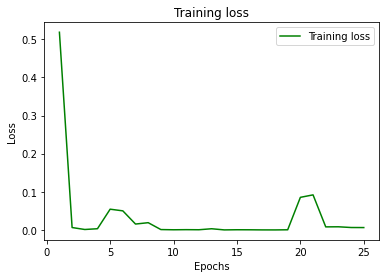

In [14]:
loss_train = densehist1.history['loss']
epochs = range(1,26)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### DenseNet121

In [9]:
# load model
model2 = DenseNet121(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model2.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model2 = Model(inputs=model2.inputs, outputs=output)
# summarize
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

__________________________________________________________________________________________________


In [10]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [13]:
denshist2 = model2.fit(X_train, y_train, batch_size = batch_size, epochs = 15)

Epoch 1/15
113/113 [==============================] - 891s 8s/step - loss: 0.6527 - Accuracy: 0.8569 - precision: 0.8658 - recall: 0.8461
Epoch 2/15
113/113 [==============================] - 876s 8s/step - loss: 0.0130 - Accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975
Epoch 3/15
113/113 [==============================] - 870s 8s/step - loss: 0.0267 - Accuracy: 0.9911 - precision: 0.9911 - recall: 0.9906
Epoch 4/15
113/113 [==============================] - 869s 8s/step - loss: 0.0169 - Accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953
Epoch 5/15
113/113 [==============================] - 870s 8s/step - loss: 0.0029 - Accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992
Epoch 6/15
113/113 [==============================] - 869s 8s/step - loss: 8.0979e-04 - Accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994
Epoch 7/15
113/113 [==============================] - 866s 8s/step - loss: 4.5504e-04 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 8/15
113/113 [======

In [14]:
predictions = model2.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       1.00      1.00      1.00       300
          FL       1.00      1.00      1.00       300
         MCL       1.00      1.00      1.00       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



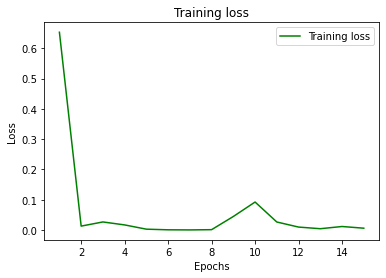

In [15]:
loss_train = denshist2.history['loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### ResNet50

In [16]:
# load model
model3 = ResNet50(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model3.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model3 = Model(inputs=model3.inputs, outputs=output)
# summarize
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [17]:
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [18]:
reshist3 = model3.fit(X_train, y_train, batch_size = batch_size, epochs = 25)

Epoch 1/25
113/113 [==============================] - 668s 6s/step - loss: 0.6305 - Accuracy: 0.8675 - precision: 0.8845 - recall: 0.8506
Epoch 2/25
113/113 [==============================] - 665s 6s/step - loss: 0.0052 - Accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986
Epoch 3/25
113/113 [==============================] - 664s 6s/step - loss: 0.0046 - Accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978
Epoch 4/25
113/113 [==============================] - 665s 6s/step - loss: 0.0026 - Accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994
Epoch 5/25
113/113 [==============================] - 665s 6s/step - loss: 0.0012 - Accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997
Epoch 6/25
113/113 [==============================] - 666s 6s/step - loss: 1.5471e-04 - Accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 7/25
113/113 [==============================] - 665s 6s/step - loss: 0.0058 - Accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983
Epoch 8/25
113/113 [==========

In [19]:
predictions = model3.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       1.00      1.00      1.00       300
          FL       1.00      1.00      1.00       300
         MCL       1.00      1.00      1.00       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



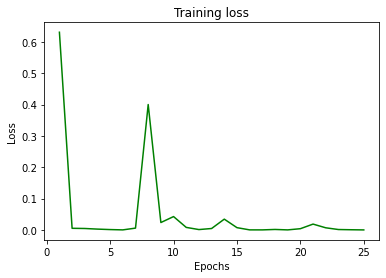

In [20]:
loss_train = reshist3.history['loss']
epochs = range(1,26)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### InceptionV3

In [22]:
# load model
model4 = InceptionV3(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model4.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model4 = Model(inputs=model4.inputs, outputs=output)
# summarize
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

 batch_normalization_99 (BatchN  (None, 25, 25, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 25, 25, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 25, 25, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 25, 25, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 12, 12, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 12, 12, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 12, 12, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 12, 12, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 12, 12, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 12, 12, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 5, 5, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 5, 5, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 5, 5, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

In [23]:
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [24]:
incepthist4 = model4.fit(X_train, y_train, batch_size = batch_size, epochs = 20)

Epoch 1/20
113/113 [==============================] - 449s 4s/step - loss: 0.4270 - Accuracy: 0.8364 - precision: 0.8598 - recall: 0.8125
Epoch 2/20
113/113 [==============================] - 444s 4s/step - loss: 0.0302 - Accuracy: 0.9892 - precision: 0.9897 - recall: 0.9889
Epoch 3/20
113/113 [==============================] - 444s 4s/step - loss: 0.0236 - Accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931
Epoch 4/20
113/113 [==============================] - 442s 4s/step - loss: 0.0480 - Accuracy: 0.9842 - precision: 0.9842 - recall: 0.9839
Epoch 5/20
113/113 [==============================] - 443s 4s/step - loss: 0.0377 - Accuracy: 0.9908 - precision: 0.9911 - recall: 0.9908
Epoch 6/20
113/113 [==============================] - 441s 4s/step - loss: 0.0337 - Accuracy: 0.9869 - precision: 0.9869 - recall: 0.9864
Epoch 7/20
113/113 [==============================] - 442s 4s/step - loss: 0.0232 - Accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928
Epoch 8/20
113/113 [==============

In [25]:
predictions = model4.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       1.00      1.00      1.00       300
          FL       1.00      1.00      1.00       300
         MCL       1.00      1.00      1.00       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



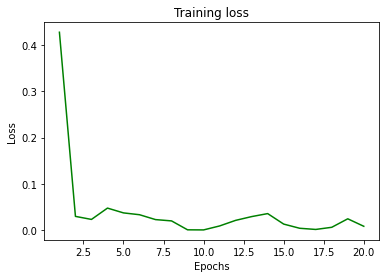

In [26]:
loss_train = incepthist4.history['loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### ResNet152

In [9]:
# load model
from keras.applications.resnet import ResNet152
model5 = ResNet152(weights='imagenet', include_top=False, input_shape= img_dim)
# add new classifier layers
flat1 = Flatten()(model5.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model5 = Model(inputs=model5.inputs, outputs=output)
# summarize
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 flatten (Flatten)              (None, 100352)       0           ['conv5_block3_out[0][0]']       
                                                                                                  
 dense (Dense)                  (None, 512)          51380736    ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 3)            1539        ['dense[0][0]']                  
                                                                                                  
Total para

In [10]:
model5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['Accuracy', 'Precision', 'Recall'])

In [11]:
reshist5 = model5.fit(X_train, y_train, batch_size = batch_size, epochs = 20)

Epoch 1/20
113/113 [==============================] - 1551s 14s/step - loss: 0.3973 - Accuracy: 0.9147 - precision: 0.9184 - recall: 0.9125
Epoch 2/20
113/113 [==============================] - 1530s 14s/step - loss: 0.0428 - Accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881
Epoch 3/20
113/113 [==============================] - 1527s 14s/step - loss: 0.0267 - Accuracy: 0.9911 - precision: 0.9914 - recall: 0.9911
Epoch 4/20
113/113 [==============================] - 1525s 13s/step - loss: 0.0751 - Accuracy: 0.9833 - precision: 0.9836 - recall: 0.9833
Epoch 5/20
113/113 [==============================] - 1522s 13s/step - loss: 0.0901 - Accuracy: 0.9839 - precision: 0.9842 - recall: 0.9833
Epoch 6/20
113/113 [==============================] - 1527s 14s/step - loss: 0.0634 - Accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847
Epoch 7/20
113/113 [==============================] - 1536s 14s/step - loss: 0.0283 - Accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936
Epoch 8/20
113/113 [

In [12]:
predictions = model5.predict(X_test)
predictions = np.argmax(predictions, axis=1)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
print(classification_report(rounded_labels,predictions,target_names = ['CLL','FL','MCL']))

              precision    recall  f1-score   support

         CLL       0.83      0.91      0.87       300
          FL       0.96      0.74      0.84       300
         MCL       0.76      0.86      0.81       300

    accuracy                           0.84       900
   macro avg       0.85      0.84      0.84       900
weighted avg       0.85      0.84      0.84       900



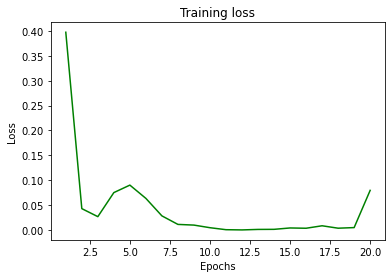

In [13]:
loss_train = reshist5.history['loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### THE END